The goal of this notebook is an exploration, and implementation, of the Kropff and Treves 2008 model for grid cells. Below is a rough flowchart of the models' processes.

![FLOWCHART](KrTr2008.png)

Before we can get to the model, we have to simulate some basic data for testing, using a random walk. Specifically, it will be similar to the one described in the paper, in that it randomly bounces off of the arena walls. The simulation will output coordinate data (x and y), but can also be used to calculate velocity if desired

In [2]:
import numpy as np
import matplotlib.pyplot as plt

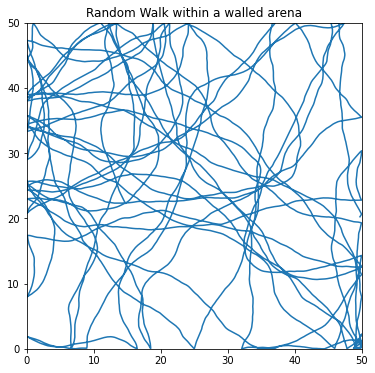

In [108]:
#Sim Parameters
aSize = 50
steps = 20000
speed = 0.1
thetaMax = 5

#Calculates vector using angle
def conv(ang):
        x = np.cos(np.radians(ang)) 
        y = np.sin(np.radians(ang)) 
        return x , y

def random_walk(aSize, steps, speed, thetaMax):

    #Plotting setup
    fig, ax = plt.subplots()
    fig.set_size_inches((6,6))
    ax.set_xlim(xmin = 0, xmax=aSize)
    ax.set_ylim(ymin = 0, ymax=aSize)
    ax.set_title('Random Walk within a walled arena')

    #random initial values
    x = [np.random.uniform(0, aSize)]
    y = [np.random.uniform(0, aSize)]
    theta = np.random.uniform(0, 360)

    #Actual random walk
    for step in range(steps-1):

        theta += np.random.uniform(-thetaMax,thetaMax)

        while (x[-1] + speed*conv(theta)[0] > aSize) or (x[-1] + speed*conv(theta)[0] < 0):
            theta = np.random.uniform(0,360)

        while (y[-1] + speed*conv(theta)[1] > aSize) or (y[-1] + speed*conv(theta)[1] < 0):
            theta = np.random.uniform(0,360)

        x.append(x[-1] + speed*conv(theta)[0])
        y.append(y[-1] + speed*conv(theta)[1])

        
    ax.plot(x,y,'-')

    plt.show()

    x = np.asarray(x)
    y = np.asarray(y)

    return np.hstack((x.reshape((-1,1)), y.reshape((-1,1))))

coords = random_walk(aSize, steps, speed, thetaMax)

Cool! First up is the pre-synaptic neural layer. These neurons are not actually a part of the grid cells (Those are the post-synaptic neurons), but rather the input. For now, they will be place cells much as in the paper. Later on, once we know the model is working, we can try different inputs. 

To keep things simple, these place cells will have circular receptive fields. The firing rate will be between 0 and 1, with firing rate inversely proportional to the distance from center of the receptive fields.

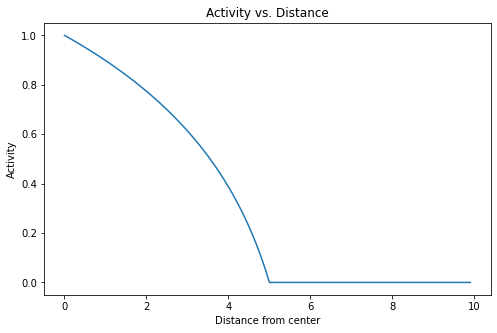

In [140]:
class placeCellNetwork():
    """
    Place cell model (What model)
    """
    def __init__(self, C, R, mu=1.0, beta=0.0):
        """
        :param vector C: Center coordinate of the receptive fields
        :param float R: Radius of the receptive fields
        :param float mu: Maximum firing rate
        :param float beta: Minimum firing rate
        """
        self.C = np.asarray(C)
        self.R = R
        self.mu =  mu
        self.beta = beta

    def calc_activity(self, L):
        d = np.linalg.norm(self.C - np.asarray(L), axis=1)
        d2 = np.copy(d)
        d2[d<=self.R] = (self.mu/np.log(self.R+1)) * np.log(-d[d<=self.R]+self.R+1) + self.beta
        d2[d>self.R] = self.beta
        return d2
        # if d > self.R:
        #     return self.beta
        # else:
        #     return (self.mu/np.log(self.R+1)) * np.log(-d+self.R+1) + self.beta

#Code is designed
pc = placeCellNetwork([[0]],5)
X = np.arange(0,10,0.1)
actList = []
for x in X:
    actList.append(pc.calc_activity(x))

fig, ax = plt.subplots()
fig.set_size_inches((8,5))
ax.plot(X, actList)
ax.set_xlabel('Distance from center')
ax.set_ylabel('Activity')
ax.set_title('Activity vs. Distance')
plt.show()

In [128]:
np.asarray([[0]])

array([0])

Now to initialize the place cell network. In this case we'll just place them randomly around the arena with constant radius and not worry about overlap.

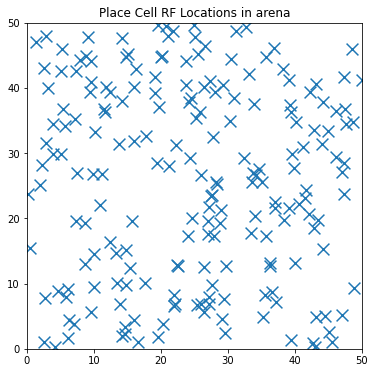

In [151]:
N1 = 200 #Number of pre-synaptic neurons, value taken from paper's stand params #to contain list of all place cells in layer
centers = np.random.uniform(0, aSize, (200,2)) #for plotting
pre_layer = placeCellNetwork(centers, 5)
#pre_layer.calc_activity([0,0])
fig, ax = plt.subplots()
fig.set_size_inches((6,6))
ax.set_xlim(xmin = 0, xmax=aSize)
ax.set_ylim(ymin = 0, ymax=aSize)
ax.set_title('Place Cell RF Locations in arena')
ax.scatter(centers[:,0], centers[:,1], s=140, marker='x')
plt.show()

In [109]:
coords

array([[49.73086404, 20.23910036],
       [49.7860911 , 20.32246684],
       [49.84025123, 20.40653039],
       ...,
       [14.62396513, 22.48641572],
       [14.67309537, 22.39931682],
       [14.71828021, 22.31010734]])

Done, now let's setup the initial parameters

In [4]:
#Other default paramters from paper
N_mEC = 100
b1 = 0.1
b2 = b1/3
sat = 30 #Psi_Saturation
a0 = 0.1 * sat
s0 = 0.3
eps = 0.001 #epsilon